# LOAD colocalisations in datasets
- use box.build_dataset
- gathers all years colocalistions types labelled in cstes.labels
- 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
#import m2lib22.aviso as aviso
#import m2lib22.cstes as cstes
#import m2lib22.diagnosis as diag

from histlib.cstes import labels, zarr_dir
from dask.distributed import Client
from dask_jobqueue import PBSCluster
from dask.distributed import wait

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.49:8787/status,
Dashboard: http://10.148.1.49:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.49:43514,Workers: 0
Dashboard: http://10.148.1.49:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
nc_files = {l: box.load_collocalisations(int(l.split('_')[-1]), drifter=l.split('_')[0], product_type=l.split('_')[1], satellite=l.split('_')[2], ) for l in labels}
nc_files

{'argos_Jason-3_2020': ['/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200101_CMEMS-L3-SLA-Jason-3__argos.nc',
  '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200201_CMEMS-L3-SLA-Jason-3__argos.nc',
  '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200301_CMEMS-L3-SLA-Jason-3__argos.nc',
  '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200401_CMEMS-L3-SLA-Jason-3__argos.nc',
  '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200501_CMEMS-L3-SLA-Jason-3__argos.nc',
  '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200601_CMEMS-L3-SLA-Jason-3__argos.nc'],
 'gps_SARAL_2020': ['/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200101_CMEMS-L3-SLA-SARAL__gps.nc',
  '/home/datawork-cersat-public/cache/users/jfpiolle/felyx/drifters/mdb_v2/2020/20200201_CMEMS-L3-SLA-SARAL__

In [21]:
for l in labels:
    print(l)
    for nc in nc_files[l]:
        ds = xr.open_dataset(nc)
        print(ds.dims)

gps_Jason-3_2020
Frozen({'obs': 15700, 'site_obs': 1489})
Frozen({'obs': 9306, 'site_obs': 1489})
Frozen({'obs': 17499, 'site_obs': 1489})
Frozen({'obs': 568, 'site_obs': 866})
argos_Jason-3_2020
Frozen({'obs': 33, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 9, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 15, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 15, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 12, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 5, 'site_obs': 1307, 'cmems_time': 211})
gps_SARAL_2020
Frozen({'obs': 11807, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 14440, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 16397, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 270, 'site_obs': 840, 'cmems_time': 211})
argos_SARAL_2020
Frozen({'obs': 26, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 17, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 22, 'site_obs': 1489, 'cmems_time': 211})
Frozen({'obs': 9, 'site_

In [4]:
# PB in Jason-gps
list_pb = []
for l in nc_files:
    for i in nc_files[l] :
        ds = xr.open_dataset(i)
        if len(ds.variables)!=51:
            list_pb.append(i)
            print(i)


KeyboardInterrupt



In [ ]:
for l in labels[3:]:
    #dask
    cluster = PBSCluster(walltime='04:00:00')
    w = cluster.scale(jobs=2)
    client = Client(cluster)
    #task
    ds = (xr.concat([box.build_dataset(nc_files[l][i], persist=True) for i in range(len(nc_files[l]))], "obs")
          .assign_attrs(__time_coverage_end=xr.open_dataset(nc_files[l][-1]).attrs['__time_coverage_end'])
          .drop_vars('site_obs')
          .chunk(dict(obs=500))
         )
    #store
    zarr = os.path.join(zarr_dir, l+".zarr")
    ds.to_zarr(zarr, mode="w")
    print(f"{l} storred in {zarr}")
    cluster.close()

gps_Cryosat-2_2020 storred in /home1/datawork/mdemol/historical_coloc/gps_Cryosat-2_2020.zarr
argos_Cryosat-2_2020 storred in /home1/datawork/mdemol/historical_coloc/argos_Cryosat-2_2020.zarr


________
# Test

In [5]:
ds = box.build_dataset(nc_files[labels[0]][0], persist=True).persist()

In [6]:
obs0 = ds.isel(obs=0).compute()

In [7]:
obs0

<xarray.Dataset>
Dimensions:                                       (site_obs: 1489,
                                                   alti_time: 211, box_x: 80,
                                                   box_y: 40, alti_time_mid: 210)
Coordinates: (12/19)
    time                                          datetime64[ns] 2020-01-02T0...
    lon                                           float64 52.31
    lat                                           float64 -21.25
    drifter_time                                  (site_obs) datetime64[ns] 2...
    drifter_lon                                   (site_obs) float64 57.69 .....
    drifter_lat                                   (site_obs) float64 -23.9 .....
    ...                                            ...
    alti_x                                        (alti_time) float64 -1.236e...
    alti_y                                        (alti_time) float64 3.542e+...
  * alti_time                                     (alti_time) int64 0 1 ... 210
  * alti_time_mid                                 (alti_time_mid) float64 0.5...
    alti_x_mid                                    (alti_time_mid) float64 -1....
    alti_y_mid                                    (alti_time_mid) float64 3.5...
Dimensions without coordinates: site_obs
Data variables: (12/68)
    __site_id                                     <U6 '145727'
    __site_name                                   <U6 '145727'
    drifter_rowsize                               (site_obs) float64 3.727e+0...
    drifter_WMO                                   (site_obs) float64 5.601e+0...
    drifter_expno                                 (site_obs) float64 6.129e+0...
    drifter_deploy_date                           (site_obs) datetime64[ns] 2...
    ...                                            ...
    alti_ggx_internal_tide                        (alti_time_mid) float64 -7....
    f                                             float64 -5.285e-05
    drifter_acc_x                                 (site_obs) float64 2.964e-0...
    drifter_acc_y                                 (site_obs) float64 -2.421e-...
    drifter_coriolis_x                            (site_obs) float64 -1.763e-...
    drifter_coriolis_y                            (site_obs) float64 -8.732e-...
Attributes:
    __id:                   CMEMS-L3-SLA-Jason-3__argos
    __time_coverage_end:    2020-02-01T00:00:00
    __time_coverage_start:  2020-01-01T00:00:00

In [6]:
ds.where(ds.box_phi==0, drop=True).box_phi.compute()

<xarray.DataArray 'box_phi' (obs: 0)>
array([], dtype=float64)
Coordinates:
    time     (obs) datetime64[ns] 
    lon      (obs) float64 
    lat      (obs) float64 
Dimensions without coordinates: obs

________
# Check open

In [13]:
ds_data = xr.open_zarr(zarr_dir+'/'+labels[3]+'.zarr')

In [14]:
ds_data

Task exception was never retrieved
future: <Task finished name='Task-1194774' coro=<Client._gather.<locals>.wait() done, defined at /home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1194775' coro=<Client._gather.<locals>.wait() done, defined at /home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


<xarray.Dataset>
Dimensions:                                       (obs: 42085, alti_time: 211,
                                                   alti_time_mid: 210,
                                                   box_y: 40, box_x: 80,
                                                   site_obs: 1489)
Coordinates: (12/19)
    alti_lat                                      (obs, alti_time) float64 dask.array<chunksize=(500, 211), meta=np.ndarray>
    alti_lon                                      (obs, alti_time) float64 dask.array<chunksize=(500, 211), meta=np.ndarray>
  * alti_time                                     (alti_time) int64 0 1 ... 210
    alti_time_                                    (obs, alti_time) datetime64[ns] dask.array<chunksize=(5261, 27), meta=np.ndarray>
  * alti_time_mid                                 (alti_time_mid) float64 0.5...
    alti_x                                        (obs, alti_time) float64 dask.array<chunksize=(500, 211), meta=np.ndarray>
    ...                                            ...
    drifter_time                                  (obs, site_obs) datetime64[ns] dask.array<chunksize=(2631, 94), meta=np.ndarray>
    drifter_x                                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_y                                     (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    lat                                           (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    lon                                           (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    time                                          (obs) datetime64[ns] dask.array<chunksize=(21043,), meta=np.ndarray>
Dimensions without coordinates: obs, site_obs
Data variables: (12/68)
    __site_id                                     (obs) object dask.array<chunksize=(21043,), meta=np.ndarray>
    __site_matchup_indice                         (obs) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    __site_name                                   (obs) object dask.array<chunksize=(21043,), meta=np.ndarray>
    alti___distance                               (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    alti___source                                 (obs) object dask.array<chunksize=(21043,), meta=np.ndarray>
    alti___source_center_index                    (obs) object dask.array<chunksize=(21043,), meta=np.ndarray>
    ...                                            ...
    drifter_typedeath                             (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_ve                                    (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vn                                    (obs, site_obs) float32 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vx                                    (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    drifter_vy                                    (obs, site_obs) float64 dask.array<chunksize=(500, 1489), meta=np.ndarray>
    f                                             (obs) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    __id:                   CMEMS-L3-SLA-Cryosat-2__gps
    __time_coverage_end:    2020-05-01T00:00:00
    __time_coverage_start:  2020-01-01T00:00:00

In [12]:
ds0 = ds_data.isel(obs=0)

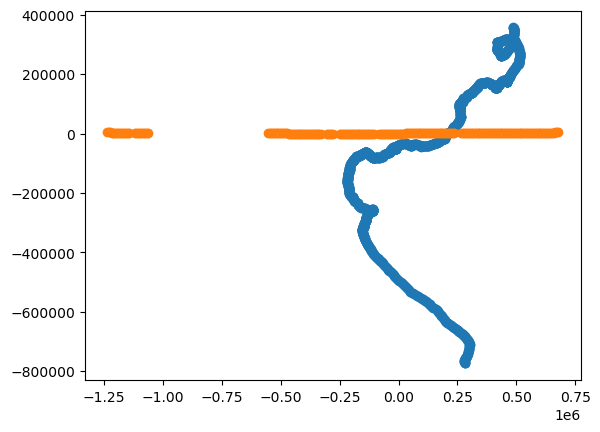

In [14]:
plt.scatter(ds0.drifter_x, ds0.drifter_y)
plt.scatter(ds0.alti_x, ds0.alti_y)

In [5]:
cluster.close()